# K-means Clustering with Same-Cluster Queries

# Imports

In [1]:
import numpy as np
import pandas as pd
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from scipy import stats

# Synthetic Data Generation

### Generate k=3 high-dimensional gaussian vectors

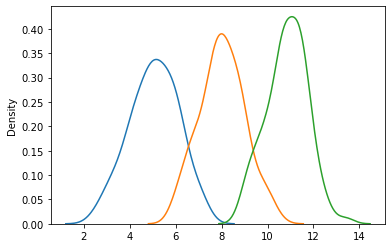

In [2]:
# Pre-determined means for clustering
means = np.array([5,8,11])
data = []

for i in means:
    # Generating k=3 high dimensional vectors
    vec = np.random.normal(loc=i, scale=1, size=100)
    data.append(vec)
    # Plot distribution of each high dimensional vector on same plot
    sns.kdeplot(vec)

### Generate Gaussian normal variables by a Gaussian mixture model
- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.fit

In [3]:
# Initialize GaussianMixture model with 3 centroids, randomly initialize with one shared covariance matrix
gmm = GaussianMixture(n_components=3, init_params='random', covariance_type='tied', random_state=0)
gmm.fit(data)

GaussianMixture(covariance_type='tied', init_params='random', n_components=3,
                random_state=0)

In [4]:
# Sample 300 vectors of size 100 from fitted GaussianMixture Model
vecs = gmm.sample(300)[0]
vecs.shape

(300, 100)

# k-means clustering using Lloyd's Algorithm

- Algorithm from https://datasciencelab.wordpress.com/2013/12/12/clustering-with-k-means-in-python/
- Modified with iteration vs. accuracy measurement

In [5]:
def cluster_points(X, mu):
    clusters  = {}
    for x in X:
        bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                    for i in enumerate(mu)], key=lambda t:t[1])[0]
        try:
            clusters[bestmukey].append(x)
        except KeyError:
            clusters[bestmukey] = [x]
    return clusters
 
def reevaluate_centers(mu, clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu
 
def has_converged(mu, oldmu):
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))
 
def kmeans(X, K, seed=42):
    # Plant seed to track random samples
    random.seed(seed)
    # Initialize to K random centers
    oldmu = random.sample(X, K)
    mu = random.sample(X, K)
    # Use to track iterations vs. accuracy 
    accuracy_dict = {}
    count = 0
    while not has_converged(mu, oldmu):
        oldmu = mu
        # Assign all points in X to clusters
        clusters = cluster_points(X, mu)
        # Calculate accuracy
        mu_means = np.array(pd.Series(mu).apply(lambda x: x.mean()))
        # Sort means in ascending order
        mu_means.sort()
        # Accuracy = 1- average error of means
        accuracy_dict[count] = 1 - np.average(np.abs(np.array(mu_means) - np.array(means)) / means)
        print('Iteration {}: {}'.format(count, mu_means))
        # Increase number of iterations by 1
        count += 1
        # Reevaluate centers
        mu = reevaluate_centers(oldmu, clusters)
    return (mu, clusters), accuracy_dict

In [6]:
accuracy_kmeans = kmeans(list(vecs), 3)[1]

Iteration 0: [ 7.90956655  9.90474765 12.66986569]
Iteration 1: [ 6.57250088  9.90571155 12.31406346]
Iteration 2: [ 6.31259307  9.52024183 12.11702112]
Iteration 3: [ 6.10813263  9.22632522 11.93242471]
Iteration 4: [ 5.93069375  8.95935996 11.71035106]
Iteration 5: [ 5.70957211  8.66639861 11.47434879]
Iteration 6: [ 5.61284294  8.5469411  11.37889995]
Iteration 7: [ 5.51503888  8.45350627 11.32821438]
Iteration 8: [ 5.44208539  8.37041829 11.25470203]
Iteration 9: [ 5.36648423  8.28798839 11.18479845]
Iteration 10: [ 5.30398075  8.19398606 11.07551525]
Iteration 11: [ 5.25618483  8.10858854 10.97646979]
Iteration 12: [ 5.22371041  8.04439442 10.90140285]
Iteration 13: [ 5.17482888  7.98144996 10.84641584]


Text(0, 0.5, 'Accuracy')

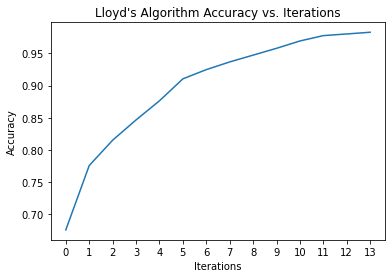

In [7]:
fig = sns.lineplot(x=accuracy_kmeans.keys(), y=accuracy_kmeans.values())
fig.set_title('Lloyd\'s Algorithm Accuracy vs. Iterations')
fig.set_xticks(range(len(accuracy_kmeans.keys())))
fig.set_xlabel('Iterations')
fig.set_ylabel('Accuracy')

# Clustering with Same-Cluster Queries

I intend to use the scipy kstest pvalue statistic to determine whether two vectors come from the same distribution in my new kmeans algorithm
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

### kstest pvalue statistic matrix from 300 sampled vectors

To visualize how the kstest pvalue statistic determines distribution similarity, I generated a 50x50 matrix from the first 50 sample vectors

In [8]:
ks_matrix = np.zeros(shape=(50,50))
for i in range(len(vecs[:50])):
    for j in range(len(vecs[:50])):
        ks_matrix[i][j] = stats.kstest(vecs[i], vecs[j]).pvalue 

<AxesSubplot:>

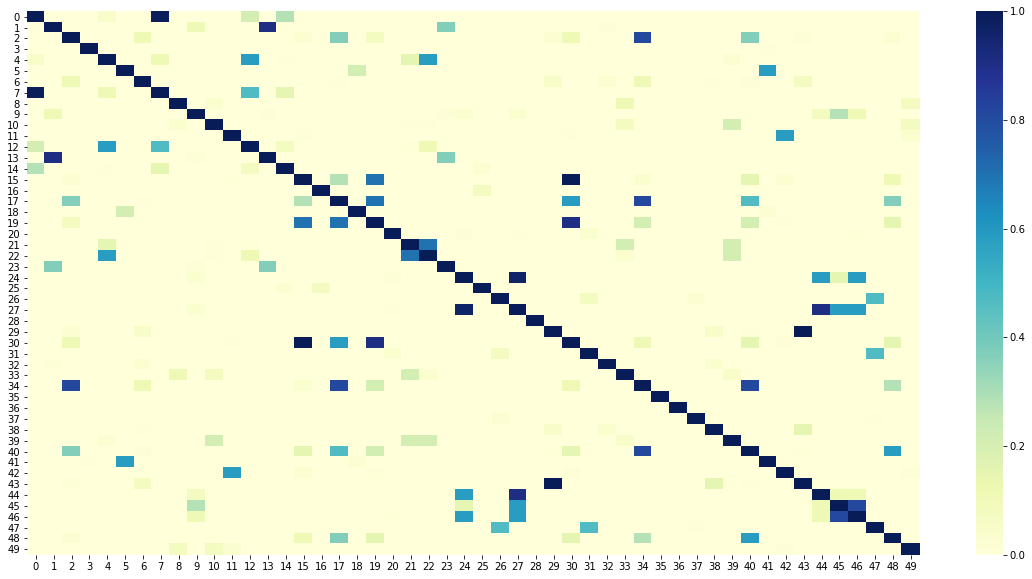

In [9]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(ks_matrix, cmap="YlGnBu", ax=ax)

### Updated kmeans Algorithm
- Read the `reevaluate_clusters` docstring for algorithm explanation

In [10]:
def cluster_points(X, mu):
    clusters  = {}
    for x in X:
        bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                    for i in enumerate(mu)], key=lambda t:t[1])[0]
        try:
            clusters[bestmukey].append(x)
        except KeyError:
            clusters[bestmukey] = [x]
    return clusters

def reevaluate_clusters(X, clusters, tol):
    '''
    Function to correct clustering errors from Lloyd's algorithm. 
    
    Calculate the kstest statistic (pvalue) of all vectors with 
    their average cluster vector to determine if the vector belongs 
    to the same distribution as the rest of the cluster. 
    
    Correct errors arising in the kmeans clustering by all vectors to 
    clusters with whose average cluster vector they have the 
    highest kstest statistic (pvalue).
    '''
    avg_vecs = {}
    pvals = {}
    removed = []
    
    # Store average cluster vectors 
    for key in clusters.keys():
        avg_vecs[key] = sum(clusters[key]) / len(clusters[key])
    
    # Remove poorly clusterd vector from cluster 
    for key in clusters.keys():
        for x in X:
            # If kstest pvalue lower than tolerance, vector is poorly clustered
            stat = stats.kstest(x, avg_vecs[key]).pvalue
            if stat < tol:
                try:
                    clusters[key].remove(x)
                    # Store removed vectors to be re-clustered
                    removed.append(x)
                except ValueError:
                    pass
    
    # Re-distribute removed vectors to the cluster with max kstest pvalue
    for vec in removed:
        for key in clusters.keys():
            # Store pvalue of kstest stat for each vector 
            pvals[key] = stats.kstest(vec, avg_vecs[key]).pvalue
        
        temp = max(pvals.values())
        key = [key for key in pvals if pvals[key] == temp]
        clusters[key[0]].append(vec)
    
    # Return re-evaluated clusters
    return clusters
 
def reevaluate_centers(mu, clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu
 
def has_converged(mu, oldmu):
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))
 
def kmeans_new(X, K, tol=0.95, seed=42):
    # Plant seed to track random samples
    random.seed(seed)
    # Initialize to K random centers
    oldmu = random.sample(X, K)
    mu = random.sample(X, K)
    # Use to track iterations vs. accuracy 
    accuracy_dict = {}
    count = 0
    while not has_converged(mu, oldmu):
        oldmu = mu
        # Assign all points in X to clusters
        clusters = cluster_points(X, mu)
        # Re-evaluate clusters
        clusters = reevaluate_clusters(X, clusters, tol)  
        # Calculate accuracy
        mu_means = np.array(pd.Series(mu).apply(lambda x: x.mean()))
        # Sort means in ascending order
        mu_means.sort()
        # Accuracy = 1- average error of means
        accuracy_dict[count] = 1 - np.average(np.abs(np.array(mu_means) - np.array(means)) / means)
        # If maximum accuracy is achieved, stop iterating
        if accuracy_dict[count] == 1:
            break
        print('Iteration {}: {}'.format(count, mu_means))
        # Increase number of iterations by 1
        count += 1
        # Reevaluate centers
        mu = reevaluate_centers(oldmu, clusters)
    return (mu, clusters), accuracy_dict

In [11]:
# Random seed = 0
accuracy_kmeans_new = kmeans_new(list(vecs), 3)[1]

Iteration 0: [ 7.90956655  9.90474765 12.66986569]
Iteration 1: [ 6.36799955  9.63576909 12.229716  ]
Iteration 2: [ 6.11995108  9.15309454 11.7407226 ]
Iteration 3: [ 5.90628196  8.77767525 11.40269089]
Iteration 4: [ 5.65397158  8.56669741 11.35108575]
Iteration 5: [ 5.58566126  8.47020035 11.25470203]
Iteration 6: [ 5.5294288   8.36408902 11.11766494]
Iteration 7: [ 5.39727187  8.25297108 11.07519723]
Iteration 8: [ 5.38203443  8.18736647 10.97569933]
Iteration 9: [ 5.31986025  8.092499   10.88251184]
Iteration 10: [ 5.30477048  8.02764469 10.79210998]
Iteration 11: [ 5.19128262  7.98073925 10.82810553]
Iteration 12: [ 5.17482888  7.97072785 10.82810553]


Text(0, 0.5, 'Accuracy')

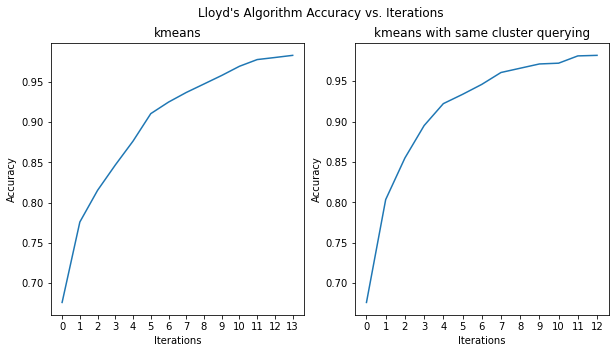

In [12]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,5))
fig.suptitle('Lloyd\'s Algorithm Accuracy vs. Iterations')

fig = sns.lineplot(x=accuracy_kmeans.keys(), y=accuracy_kmeans.values(), ax=axes[0])
axes[0].set_title('kmeans')
axes[0].set_xticks(range(len(accuracy_kmeans.keys())))
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Accuracy')

sns.lineplot(x=accuracy_kmeans_new.keys(), y=accuracy_kmeans_new.values(), ax=axes[1])
axes[1].set_title('kmeans with same cluster querying')
axes[1].set_xticks(range(len(accuracy_kmeans_new.keys())))
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Accuracy')

# Testing

In [13]:
kmeans_i = []
kmeans_a = []
kmeans_time = []

kmeans_sc_i = []
kmeans_sc_a = []
kmeans_sc_time = []

# Test kmeans vs. kmeans_new 100 times with different random seeds for different random initializations 
for i in range(100):
    t0 = time.time()
    accuracy_kmeans = kmeans(list(vecs), 3, seed=i)[1]
    t1 = time.time()
    kmeans_time.append(t1-t0)
    kmeans_i.append(np.max(list(accuracy_kmeans.keys())))
    kmeans_a.append(np.max(list(accuracy_kmeans.values())))
    
    t2 = time.time()
    accuracy_kmeans_new = kmeans_new(list(vecs), 3, seed=i)[1]
    t3 = time.time()
    kmeans_sc_time.append(t3-t2)
    kmeans_sc_i.append(np.max(list(accuracy_kmeans_new.keys())))
    kmeans_sc_a.append(np.max(list(accuracy_kmeans_new.values())))

Iteration 0: [ 7.54326869  8.47025947 11.49392601]
Iteration 1: [ 6.26172714  9.06622393 11.32821438]
Iteration 2: [ 5.93069375  8.79897825 11.40269089]
Iteration 3: [ 5.65397158  8.57715093 11.37889995]
Iteration 4: [ 5.54337927  8.47367649 11.32821438]
Iteration 5: [ 5.44208539  8.37041829 11.25470203]
Iteration 6: [ 5.36648423  8.28798839 11.18479845]
Iteration 7: [ 5.30398075  8.19398606 11.07551525]
Iteration 8: [ 5.25618483  8.10858854 10.97646979]
Iteration 9: [ 5.22371041  8.04439442 10.90140285]
Iteration 10: [ 5.17482888  7.98144996 10.84641584]
Iteration 0: [ 7.54326869  8.47025947 11.49392601]
Iteration 1: [ 6.23907266  9.09397071 11.42660003]
Iteration 2: [ 5.9188692   8.77509463 11.37889995]
Iteration 3: [ 5.65397158  8.56669741 11.35108575]
Iteration 4: [ 5.58566126  8.47020035 11.25470203]
Iteration 5: [ 5.5294288   8.36408902 11.11766494]
Iteration 6: [ 5.39727187  8.25297108 11.07519723]
Iteration 7: [ 5.38203443  8.18736647 10.97569933]
Iteration 8: [ 5.31986025  8.0

Iteration 2: [ 4.93801306  7.51256672 10.39092011]
Iteration 3: [ 5.14436463  7.74579697 10.50908352]
Iteration 4: [ 5.20758131  7.91727036 10.70251285]
Iteration 5: [ 5.17482888  7.93844155 10.77449285]
Iteration 0: [ 8.28569936  9.38575494 10.8086342 ]
Iteration 1: [ 6.57245852  9.56987941 11.47385325]
Iteration 2: [ 6.18954988  9.19509024 11.68085805]
Iteration 3: [ 5.95497597  8.94080894 11.62619315]
Iteration 4: [ 5.70957211  8.65340036 11.45073303]
Iteration 5: [ 5.5992601   8.53664952 11.37889995]
Iteration 6: [ 5.50082591  8.44336573 11.32821438]
Iteration 7: [ 5.44208539  8.37041829 11.25470203]
Iteration 8: [ 5.36648423  8.28798839 11.18479845]
Iteration 9: [ 5.30398075  8.19398606 11.07551525]
Iteration 10: [ 5.25618483  8.10858854 10.97646979]
Iteration 11: [ 5.22371041  8.04439442 10.90140285]
Iteration 12: [ 5.17482888  7.98144996 10.84641584]
Iteration 0: [ 8.28569936  9.38575494 10.8086342 ]
Iteration 1: [ 6.2687696   9.27062069 11.64094221]
Iteration 2: [ 6.02599141  8

Iteration 10: [ 5.30477048  8.06137707 10.84417988]
Iteration 11: [ 5.30389362  8.01745525 10.77449285]
Iteration 12: [ 5.19128262  7.98073925 10.82810553]
Iteration 13: [ 5.17482888  7.97072785 10.82810553]
Iteration 0: [4.47236498 7.00118269 7.82143482]
Iteration 1: [4.9248401  6.44490497 9.06571569]
Iteration 2: [4.74763578 6.86629638 9.6305904 ]
Iteration 3: [ 4.66603176  7.13625759 10.07634113]
Iteration 4: [ 4.75997922  7.33024947 10.28477527]
Iteration 5: [ 4.86621842  7.45954636 10.37587112]
Iteration 6: [ 4.90182991  7.52481287 10.43503478]
Iteration 7: [ 4.97162743  7.58956813 10.46486631]
Iteration 8: [ 5.02105325  7.6555131  10.5100352 ]
Iteration 9: [ 5.06779143  7.70058341 10.524915  ]
Iteration 10: [ 5.12963812  7.76731693 10.555214  ]
Iteration 11: [ 5.1595052   7.82262836 10.60238564]
Iteration 12: [ 5.1595052   7.87591768 10.68530473]
Iteration 13: [ 5.17482888  7.92804246 10.75639321]
Iteration 14: [ 5.17482888  7.93844155 10.77449285]
Iteration 0: [4.47236498 7.0011

Iteration 7: [ 5.36648423  8.28798839 11.18479845]
Iteration 8: [ 5.30398075  8.19398606 11.07551525]
Iteration 9: [ 5.25618483  8.10858854 10.97646979]
Iteration 10: [ 5.22371041  8.04439442 10.90140285]
Iteration 11: [ 5.17482888  7.98144996 10.84641584]
Iteration 0: [ 9.58867162  9.95746603 10.78855163]
Iteration 1: [ 6.5734848   8.95374533 11.44924132]
Iteration 2: [ 6.01454197  8.86199697 11.37889995]
Iteration 3: [ 5.70957211  8.6158465  11.37889995]
Iteration 4: [ 5.5716017   8.49370103 11.32821438]
Iteration 5: [ 5.5294288   8.36408902 11.11766494]
Iteration 6: [ 5.39727187  8.25297108 11.07519723]
Iteration 7: [ 5.38203443  8.18736647 10.97569933]
Iteration 8: [ 5.31986025  8.092499   10.88251184]
Iteration 9: [ 5.30477048  8.02764469 10.79210998]
Iteration 10: [ 5.19128262  7.98073925 10.82810553]
Iteration 11: [ 5.17482888  7.97072785 10.82810553]
Iteration 0: [ 5.00098238  5.96889455 12.46835081]
Iteration 1: [ 4.54303906  7.45469002 10.7203876 ]
Iteration 2: [ 4.81451653  

Iteration 0: [5.10147353 5.56635093 9.17927451]
Iteration 1: [4.29167644 6.50840995 9.59878796]
Iteration 2: [ 4.44387543  6.97643264 10.00839496]
Iteration 3: [ 4.8493606   7.38881246 10.28250616]
Iteration 4: [ 4.88395858  7.52510785 10.44988805]
Iteration 5: [ 5.12971848  7.71250923 10.47856125]
Iteration 6: [ 5.16003847  7.81211273 10.58549693]
Iteration 7: [ 5.20758131  7.94803237 10.75639321]
Iteration 8: [ 5.17482888  7.93844155 10.77449285]
Iteration 0: [5.90092285 7.63707103 7.96362974]
Iteration 1: [5.29903983 7.40132519 9.71715357]
Iteration 2: [ 5.08565119  7.50994922 10.23918729]
Iteration 3: [ 5.05238919  7.58971268 10.39092011]
Iteration 4: [ 5.06779143  7.65610898 10.46486631]
Iteration 5: [ 5.06779143  7.68926381 10.5100352 ]
Iteration 6: [ 5.11464229  7.74483941 10.53999141]
Iteration 7: [ 5.14512598  7.81103071 10.60238564]
Iteration 8: [ 5.1595052   7.87591768 10.68530473]
Iteration 9: [ 5.17482888  7.92804246 10.75639321]
Iteration 10: [ 5.17482888  7.93844155 10.7

Iteration 6: [ 5.17482888  7.93844155 10.77449285]
Iteration 7: [ 5.17482888  7.93844155 10.77449285]
Iteration 0: [ 4.43603778  8.62081696 11.25941009]
Iteration 1: [ 5.16346461  8.19037832 11.24796959]
Iteration 2: [ 5.20849711  8.12264356 11.05498927]
Iteration 3: [ 5.19128262  8.0353455  10.91990238]
Iteration 4: [ 5.17482888  7.99250236 10.86433477]
Iteration 5: [ 5.17482888  7.98144996 10.84641584]
Iteration 0: [ 4.43603778  8.62081696 11.25941009]
Iteration 1: [ 5.36753225  8.21016431 11.03506907]
Iteration 2: [ 5.33592012  8.12424126 10.91927959]
Iteration 3: [ 5.30477048  8.0725305  10.86201098]
Iteration 4: [ 5.30389362  8.01745525 10.77449285]
Iteration 5: [ 5.19128262  7.98073925 10.82810553]
Iteration 6: [ 5.17482888  7.97072785 10.82810553]
Iteration 0: [4.71430639 9.08157472 9.90474765]
Iteration 1: [ 5.35103459  8.10543875 10.85687416]
Iteration 2: [ 5.25618483  8.05334187 10.88251184]
Iteration 3: [ 5.19128262  7.99146666 10.84641584]
Iteration 4: [ 5.17482888  7.98144

Iteration 8: [ 5.12963812  7.76731693 10.555214  ]
Iteration 9: [ 5.1595052   7.82262836 10.60238564]
Iteration 10: [ 5.1595052   7.87591768 10.68530473]
Iteration 11: [ 5.17482888  7.92804246 10.75639321]
Iteration 12: [ 5.17482888  7.93844155 10.77449285]
Iteration 0: [ 4.0080721   6.46159403 11.91044987]
Iteration 1: [ 4.81413036  7.48045576 10.44971768]
Iteration 2: [ 4.9052566   7.54492136 10.46486631]
Iteration 3: [ 5.14436463  7.73494205 10.4937354 ]
Iteration 4: [ 5.17482888  7.88697601 10.68500915]
Iteration 5: [ 5.17482888  7.93844155 10.77449285]
Iteration 6: [ 5.17482888  7.93844155 10.77449285]
Iteration 0: [5.19215155 5.99438133 7.86738234]
Iteration 1: [4.70446517 6.29054197 9.14703443]
Iteration 2: [4.44651056 6.68565966 9.64513317]
Iteration 3: [4.50348349 6.98457554 9.99015619]
Iteration 4: [ 4.60534565  7.20886516 10.24007151]
Iteration 5: [ 4.75997922  7.39186011 10.37587112]
Iteration 6: [ 4.86621842  7.48115569 10.40556597]
Iteration 7: [ 4.90182991  7.53582882 10

Iteration 8: [ 5.30398075  8.19398606 11.07551525]
Iteration 9: [ 5.25618483  8.10858854 10.97646979]
Iteration 10: [ 5.22371041  8.04439442 10.90140285]
Iteration 11: [ 5.17482888  7.98144996 10.84641584]
Iteration 0: [ 7.40435864  9.48457693 10.85410017]
Iteration 1: [ 6.47083745  9.35818168 11.42660003]
Iteration 2: [ 6.08589071  8.98122036 11.47224878]
Iteration 3: [ 5.81742072  8.71885736 11.42660003]
Iteration 4: [ 5.64007377  8.55686235 11.35108575]
Iteration 5: [ 5.5716017   8.42752118 11.18374072]
Iteration 6: [ 5.51503888  8.3433868  11.09583894]
Iteration 7: [ 5.44239225  8.21538842 10.9562726 ]
Iteration 8: [ 5.33529282  8.10242221 10.88251184]
Iteration 9: [ 5.30477048  8.06137707 10.84417988]
Iteration 10: [ 5.30389362  8.01745525 10.77449285]
Iteration 11: [ 5.19128262  7.98073925 10.82810553]
Iteration 12: [ 5.17482888  7.97072785 10.82810553]
Iteration 0: [5.19215155 7.61288928 9.58867162]
Iteration 1: [ 5.08565119  7.64316783 10.35574613]
Iteration 2: [ 5.08360758  7.

Iteration 2: [ 4.92258391  7.55579713 10.46486631]
Iteration 3: [ 5.00649394  7.64423468 10.50908352]
Iteration 4: [ 5.08399053  7.72273    10.53970201]
Iteration 5: [ 5.16003847  7.87602481 10.68460707]
Iteration 6: [ 5.17482888  7.93844155 10.77449285]
Iteration 7: [ 5.17482888  7.93844155 10.77449285]
Iteration 0: [ 9.10906748 10.01565181 10.85410017]
Iteration 1: [ 6.89987033  9.86784685 11.54552166]
Iteration 2: [ 6.40109325  9.53422951 11.89837045]
Iteration 3: [ 6.11972829  9.20938153 11.86572872]
Iteration 4: [ 5.91828088  8.93511542 11.68203828]
Iteration 5: [ 5.70957211  8.65340036 11.45073303]
Iteration 6: [ 5.5992601   8.53664952 11.37889995]
Iteration 7: [ 5.50082591  8.44336573 11.32821438]
Iteration 8: [ 5.44208539  8.37041829 11.25470203]
Iteration 9: [ 5.36648423  8.28798839 11.18479845]
Iteration 10: [ 5.30398075  8.19398606 11.07551525]
Iteration 11: [ 5.25618483  8.10858854 10.97646979]
Iteration 12: [ 5.22371041  8.04439442 10.90140285]
Iteration 13: [ 5.17482888  

Iteration 5: [ 5.19128262  7.98073925 10.82810553]
Iteration 6: [ 5.17482888  7.97072785 10.82810553]
Iteration 0: [5.00098238 7.52062324 7.89392327]
Iteration 1: [5.02146802 7.01638919 9.24373919]
Iteration 2: [4.91115276 7.19052952 9.93120304]
Iteration 3: [ 4.86621842  7.36790871 10.24007151]
Iteration 4: [ 4.88395858  7.47044569 10.37587112]
Iteration 5: [ 4.90182991  7.52481287 10.43503478]
Iteration 6: [ 4.97162743  7.58956813 10.46486631]
Iteration 7: [ 5.02105325  7.6555131  10.5100352 ]
Iteration 8: [ 5.06779143  7.70058341 10.524915  ]
Iteration 9: [ 5.12963812  7.76731693 10.555214  ]
Iteration 10: [ 5.1595052   7.82262836 10.60238564]
Iteration 11: [ 5.1595052   7.87591768 10.68530473]
Iteration 12: [ 5.17482888  7.92804246 10.75639321]
Iteration 13: [ 5.17482888  7.93844155 10.77449285]
Iteration 0: [5.00098238 7.52062324 7.89392327]
Iteration 1: [ 5.18568776  7.30980708 10.02868131]
Iteration 2: [ 5.02243825  7.57882847 10.40387271]
Iteration 3: [ 5.08399053  7.67890688 1

Iteration 0: [ 7.72739931 10.00512729 10.67087474]
Iteration 1: [ 6.5379416   9.75470912 11.87389838]
Iteration 2: [ 6.23551194  9.34207444 11.89444747]
Iteration 3: [ 6.02599141  9.02330167 11.64923905]
Iteration 4: [ 5.81742072  8.72014223 11.42356773]
Iteration 5: [ 5.64007377  8.55686235 11.35108575]
Iteration 6: [ 5.5716017   8.42752118 11.18374072]
Iteration 7: [ 5.51503888  8.3433868  11.09583894]
Iteration 8: [ 5.44239225  8.21538842 10.9562726 ]
Iteration 9: [ 5.33529282  8.10242221 10.88251184]
Iteration 10: [ 5.30477048  8.06137707 10.84417988]
Iteration 11: [ 5.30389362  8.01745525 10.77449285]
Iteration 12: [ 5.19128262  7.98073925 10.82810553]
Iteration 13: [ 5.17482888  7.97072785 10.82810553]
Iteration 0: [ 7.86738234  9.19719509 11.61030387]
Iteration 1: [ 6.43484585  9.40085355 11.54552166]
Iteration 2: [ 6.10813263  9.08711669 11.62619315]
Iteration 3: [ 5.880964    8.80981706 11.49837997]
Iteration 4: [ 5.65397158  8.57715093 11.37889995]
Iteration 5: [ 5.54337927  

Iteration 0: [ 5.47698193  9.58867162 10.31717669]
Iteration 1: [ 5.89858208  8.54732523 10.93301102]
Iteration 2: [ 5.61389854  8.4241532  11.11635226]
Iteration 3: [ 5.50082591  8.32208885 11.07509978]
Iteration 4: [ 5.42709407  8.19413484 10.9383917 ]
Iteration 5: [ 5.33529282  8.10242221 10.88251184]
Iteration 6: [ 5.30477048  8.06137707 10.84417988]
Iteration 7: [ 5.30389362  8.01745525 10.77449285]
Iteration 8: [ 5.19128262  7.98073925 10.82810553]
Iteration 9: [ 5.17482888  7.97072785 10.82810553]
Iteration 0: [5.80033209 6.23185809 8.57194451]
Iteration 1: [4.88568019 6.76328022 9.40655349]
Iteration 2: [4.66731722 7.05872318 9.96274778]
Iteration 3: [ 4.70459832  7.26536466 10.24007151]
Iteration 4: [ 4.83174605  7.43689276 10.37587112]
Iteration 5: [ 4.88395858  7.5140942  10.43503478]
Iteration 6: [ 4.90182991  7.54680737 10.46486631]
Iteration 7: [ 4.97162743  7.60069453 10.47974886]
Iteration 8: [ 5.0368532   7.66669265 10.5100352 ]
Iteration 9: [ 5.06779143  7.70058341 10

Iteration 8: [ 5.12963812  7.76731693 10.555214  ]
Iteration 9: [ 5.1595052   7.82262836 10.60238564]
Iteration 10: [ 5.1595052   7.87591768 10.68530473]
Iteration 11: [ 5.17482888  7.92804246 10.75639321]
Iteration 12: [ 5.17482888  7.93844155 10.77449285]
Iteration 0: [5.77116824 6.75623166 8.86775079]
Iteration 1: [ 5.09958117  7.5022077  10.20998888]
Iteration 2: [ 5.1595052   7.74510942 10.49479765]
Iteration 3: [ 5.20758131  7.91727036 10.70251285]
Iteration 4: [ 5.17482888  7.93844155 10.77449285]
Iteration 0: [7.05017005 9.74780604 9.85038122]
Iteration 1: [ 6.39032024  9.96225195 10.3488006 ]
Iteration 2: [ 6.29312817  9.36800433 10.88611145]
Iteration 3: [ 6.06120674  8.93837051 11.41581939]
Iteration 4: [ 5.80445144  8.69605366 11.40269089]
Iteration 5: [ 5.64007377  8.56731107 11.37889995]
Iteration 6: [ 5.52924466  8.46359238 11.32821438]
Iteration 7: [ 5.44208539  8.37041829 11.25470203]
Iteration 8: [ 5.36648423  8.28798839 11.18479845]
Iteration 9: [ 5.30398075  8.19398

In [14]:
'kmeans mean iterations: {}, \
kmeans mean accuracy: {}, \
kmeans mean time: {}'.format(np.average(kmeans_i), np.average(kmeans_a), np.average(kmeans_time))

'kmeans mean iterations: 10.35, kmeans mean accuracy: 0.9808760553673391, kmeans mean time: 19.3713565325737'

In [15]:
'kmeans_new mean iterations: {}, \
kmeans_new mean accuracy: {}, \
kmeans_new mean time: {}'.format(np.average(kmeans_sc_i), np.average(kmeans_sc_a), np.average(kmeans_sc_time))

'kmeans_new mean iterations: 8.06, kmeans_new mean accuracy: 0.980490478600525, kmeans_new mean time: 6.695985975265503'